In [6]:
import csv
import os
#import cv2
from copy import deepcopy
from typing import List, Tuple
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms.functional as F
import torchvision.transforms as transforms
import pandas as pd
from skimage.transform import rotate
import random
from glob import glob
import rasterio
from torch.utils.data import DataLoader
from glob import glob 
import matplotlib.pyplot as plt
import torch.nn as nn

In [16]:
import csv
import os
#import cv2
from copy import deepcopy
from typing import List, Tuple
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms.functional as F
import torchvision.transforms as transforms
import pandas as pd
from skimage.transform import rotate
import random
import rasterio

class TrainDataset():
    def __init__(self, image_id, label_id, is_robustness,dict_format=True):

        self.image_id = image_id
        self.label_id = label_id
        self.is_robustness = is_robustness
        self.dict_format=dict_format

        self.image_list = [f"../ai4boundaries_data/orthophoto/images/train/{x}_ortho_1m_512.tif" for x in self.image_id]
        self.label_list = [f"../ai4boundaries_data/orthophoto/masks/train/{x}_ortholabel_1m_512.tif" for x in self.image_id]

        if self.is_robustness:
            self.image_list, self.label_list = self.get_images_and_labels_path_for_loop()

    def __getitem__(self, item):

        image_path = self.image_list[item]
        #image_path = os.path.join(self.image_path, image_name)
        input_image = self.__open_tiff__(image_path)
        input_image = self.min_max_normalize(input_image)
        input_image = self.resize_array(input_image,(1024,1024))
        #input_image = image.resize((1024, 1024), Image.ANTIALIAS)
        input_image = torch.tensor(input_image).float()

        label_path = self.label_list[item]
        #label_path = os.path.join(self.label_path, label_name)
        input_label = self.__open_tiff__(label_path)
        input_label = self.resize_array(input_label,(512,512))
        input_label=input_label[1,:,:]
        
        #label = label.resize((256, 256), Image.ANTIALIAS)

        input_label = torch.tensor(input_label)

        points_scale = np.array(input_image.shape[1:])[None, ::-1]
        point_grids = build_all_layer_point_grids(
            n_per_side=32,
            n_layers=0,
            scale_per_layer=1,
        )
        points_for_image = point_grids[0] * points_scale
        in_points = torch.as_tensor(points_for_image)
        in_labels = torch.ones(in_points.shape[0], dtype=torch.int)
        points = (in_points, in_labels)

        if self.dict_format:
            inout = 1
            point_label = 1
            boxes = []
            box_old = []
            pt = np.array([0, 0])
            bboxes = []

            pt = points_for_image
            point_label = np.array(in_labels)

            name = image_path.split('/')[-1].split(".tif")[0]
            image_meta_dict = {'filename_or_obj': name}
            return {
                'image': input_image[[2,1,0],:,:],
                'label': input_label,
                'p_label': point_label,
                'pt': pt,
                'box': boxes,
                # 'box_old':box_old,
                'image_meta_dict': image_meta_dict,
                'ground_truth_bboxes': bboxes
            }

        return input_image, input_label, points

    def __len__(self):

        return len(self.image_list)
    
    def min_max_normalize(self,image):
        # Assuming image shape is n_channels x height x width
        channel_mins=np.min(image,axis=(1,2,),keepdims=True)
        channel_maxs=np.max(image,axis=(1,2),keepdims=True) 
        normalized_array = (image-channel_mins)/(channel_maxs-channel_mins)
        return normalized_array

    def __open_tiff__(self,image_path):
        image=rasterio.open(image_path).read()
        return image
        
    def resize_array(self,array, new_size):
        # Transpose the array to height x width x channels
        array = np.transpose(array, (1, 2, 0))

        array = array * 255
        # Convert to PIL Image
        pil_image = Image.fromarray(array.astype(np.uint8))

        # Resize the image
        resized_image = pil_image.resize(new_size,Image.Resampling.NEAREST)

        # Convert back to numpy array
        resized_array = np.array(resized_image)

        # Transpose back to channels x height x width
        resized_array = np.transpose(resized_array, (2, 0, 1))
        
        resized_array = resized_array/255

        return resized_array

def build_all_layer_point_grids(
    n_per_side: int, n_layers: int, scale_per_layer: int
) -> List[np.ndarray]:
    """Generates point grids for all crop layers."""
    points_by_layer = []
    for i in range(n_layers + 1):
        n_points = int(n_per_side / (scale_per_layer**i))
        points_by_layer.append(build_point_grid(n_points))
    return points_by_layer

def build_point_grid(n_per_side: int) -> np.ndarray:
    """Generates a 2D grid of points evenly spaced in [0,1]x[0,1]."""
    offset = 1 / (2 * n_per_side)
    points_one_side = np.linspace(offset, 1 - offset, n_per_side)
    points_x = np.tile(points_one_side[None, :], (n_per_side, 1))
    points_y = np.tile(points_one_side[:, None], (1, n_per_side))
    points = np.stack([points_x, points_y], axis=-1).reshape(-1, 2)
    return points

def get_images_and_labels_path(data_path, mode):

    label_list = sorted([os.path.join(data_path, mode, "labels", label_file) for label_file in os.listdir(os.path.join(data_path, mode, "labels"))])
    image_list = sorted([os.path.join(data_path, mode, "images", image_file) for image_file in os.listdir(os.path.join(data_path, mode, "images"))])

    print(mode, "data length:", len(label_list), len(image_list))

    return label_list, image_list

In [81]:
class Ai4smallDataset():
    def __init__(self,image_list,flag,dict_format=True):

        self.image_list = image_list
        self.image_ids = [x.split("/")[-1].split(".")[0] for x in self.image_list]
        self.parcel_list= [f"/home/geovisionaries/sambal/original/sentinel-2-asia/parcel_mask/{x}.tif" for x in self.image_ids]
        self.mask_list= [f"/home/geovisionaries/sambal/original/sentinel-2-asia/{flag}/masks/{x}.tif" for x in self.image_ids]
        self.dict_format=dict_format

    def __getitem__(self, item):

        image_path = self.image_list[item]
        #image_path = os.path.join(self.image_path, image_name)
        input_image = self.__open_tiff__(image_path)
        input_image = input_image[[2,1,0],:,:]
        input_image = self.min_max_normalize(input_image)
        input_image = self.resize_array(input_image,(512,512))
        #input_image = image.resize((1024, 1024), Image.ANTIALIAS)
        input_image = torch.tensor(input_image).float()

        parcel_path = self.parcel_list[item]
        parcel_label = self.__open_tiff__(parcel_path)
        parcel_label = self.resize_array(parcel_label,(512,512),mask=True)
        parcel_label = torch.tensor(parcel_label)
    
        mask_path = self.mask_list[item]
        #label_path = os.path.join(self.parcel_path, label_name)
        mask_label = self.__open_tiff__(mask_path)
        mask_label = np.where(mask_label>0,1,0)
        mask_label = self.resize_array(mask_label,(512,512),mask=True)
        mask_label = torch.tensor(mask_label)
        return input_image,mask_label,parcel_label

    def __len__(self):

        return len(self.image_list)
    
    def min_max_normalize(self,image):
        # Assuming image shape is n_channels x height x width
        channel_mins=np.min(image,axis=(1,2,),keepdims=True)
        channel_maxs=np.max(image,axis=(1,2),keepdims=True) 
        normalized_array = (image-channel_mins)/(channel_maxs-channel_mins)
        return normalized_array

    def __open_tiff__(self,image_path):
        image=rasterio.open(image_path).read()
        return image
        
    def resize_array(self,array, new_size,mask=False):
        # Transpose the array to height x width x channels
        array = np.transpose(array, (1, 2, 0))
        if mask:
            array=np.squeeze(array,2)
            

        array = array * 255
        # Convert to PIL Image
        pil_image = Image.fromarray(array.astype(np.uint8))

        # Resize the image
        resized_image = pil_image.resize(new_size,Image.Resampling.NEAREST)

        # Convert back to numpy array
        resized_array = np.array(resized_image)
        if mask:
            resized_array=np.expand_dims(resized_array,2)

        # Transpose back to channels x height x width
        resized_array = np.transpose(resized_array, (2, 0, 1))
        
        resized_array = resized_array/255

        return resized_array

In [82]:
train_image_list=glob("/home/geovisionaries/sambal/original/sentinel-2-asia/train/images/*")
val_image_list=glob("/home/geovisionaries/sambal/original/sentinel-2-asia/validate/images/*")

train_data=Ai4smallDataset(train_image_list,flag='train')
trainLoader = DataLoader(dataset=train_data, batch_size=1, shuffle=True)

val_data=Ai4smallDataset(val_image_list,flag='validate')
valLoader = DataLoader(dataset=val_data, batch_size=1, shuffle=False)

In [83]:
train_image_list

['/home/geovisionaries/sambal/original/sentinel-2-asia/train/images/52_vietnam.tif',
 '/home/geovisionaries/sambal/original/sentinel-2-asia/train/images/44_vietnam.tif',
 '/home/geovisionaries/sambal/original/sentinel-2-asia/train/images/51_vietnam.tif',
 '/home/geovisionaries/sambal/original/sentinel-2-asia/train/images/24_vietnam.tif',
 '/home/geovisionaries/sambal/original/sentinel-2-asia/train/images/37_cambodia.tif',
 '/home/geovisionaries/sambal/original/sentinel-2-asia/train/images/40_vietnam.tif',
 '/home/geovisionaries/sambal/original/sentinel-2-asia/train/images/31_vietnam.tif',
 '/home/geovisionaries/sambal/original/sentinel-2-asia/train/images/39_cambodia.tif',
 '/home/geovisionaries/sambal/original/sentinel-2-asia/train/images/4_cambodia.tif',
 '/home/geovisionaries/sambal/original/sentinel-2-asia/train/images/55_vietnam.tif',
 '/home/geovisionaries/sambal/original/sentinel-2-asia/train/images/36_cambodia.tif',
 '/home/geovisionaries/sambal/original/sentinel-2-asia/train/i

In [84]:
pack=next(iter(trainLoader))

In [85]:
pack[1].size()

torch.Size([1, 1, 512, 512])

In [90]:
imgs = pack[0]
masks = pack[2]
print(masks.size())

torch.Size([1, 1, 512, 512])


In [91]:
image_np=imgs.squeeze(0)[:,:,:].permute(1,2,0).numpy()
masks_np=masks.squeeze(0).permute(1,2,0).numpy()

In [92]:
np.unique(masks)

array([0., 1.])

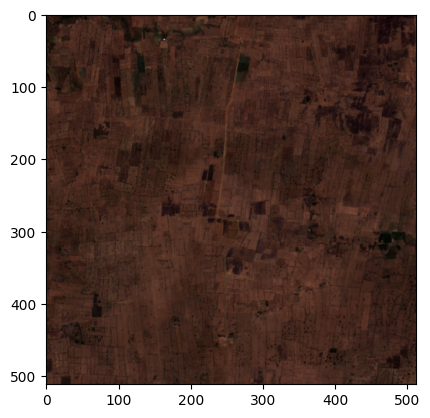

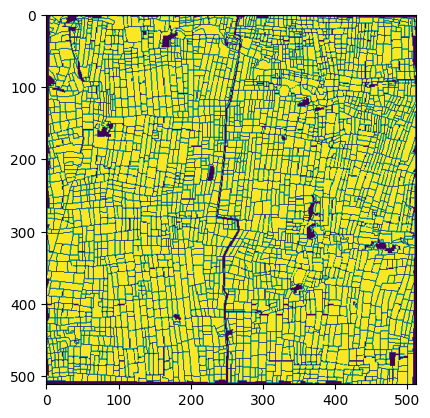

In [93]:
plt.imshow(image_np)
plt.show()
plt.imshow(masks_np)
plt.show()

In [23]:
np.unique(masks_np)

array([0., 1.])

In [112]:
plt.imshow(parcel_np)
plt.show()
plt.imshow(rasterio.open('../original/sentinel-2-asia/parcel_mask/15_cambodia.tif').read().transpose(1,2,0))
plt.show()

NameError: name 'parcel_np' is not defined

In [22]:
class upDecoder(nn.Module):
    def __init__(self):
        super(upDecoder, self).__init__()
        # Define the decoder layers
        self.up_1 = nn.Sequential(
            nn.ConvTranspose2d(256, 256, kernel_size=2, stride=2),  # Output size: (N, 512, 128, 128)
            nn.Conv2d(256,128, kernel_size=3, padding=1),           # Output size: (N, 512, 128, 128)
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        
        self.up_2=nn.Sequential(
            nn.ConvTranspose2d(128,128, kernel_size=2, stride=2),  # Output size: (N, 256, 256, 256)
            nn.Conv2d(128,64, kernel_size=3, padding=1),           # Output size: (N, 256, 256, 256)
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        self.up_3=nn.Sequential(
            nn.ConvTranspose2d(64,64, kernel_size=2, stride=2),  # Output size: (N, 256, 256, 256)
            nn.Conv2d(64,32, kernel_size=3, padding=1),           # Output size: (N, 256, 256, 256)
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        

        self.conv_1=nn.Sequential(
            nn.Conv2d(32,16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16,1, kernel_size=1) 
        )
    
        self.merge_1=nn.Sequential(
            nn.Conv2d(256*2,256, kernel_size=1),
            nn.ReLU()
        )
        self.merge_2=nn.Sequential(
            nn.Conv2d(128*2,128, kernel_size=1),
            nn.ReLU()
        )
        
        self.merge_3=nn.Sequential(
            nn.Conv2d(64*2,64, kernel_size=1),
            nn.ReLU()
        )

        self.mid_feat_1=nn.Sequential(
            nn.Conv2d(768,256, kernel_size=1),
            nn.ReLU()
        )
        
        self.mid_feat_2=nn.Sequential(
            nn.ConvTranspose2d(768,256, kernel_size=2, stride=2),  # Output size: (N, 512, 128, 128)
            nn.Conv2d(256,128, kernel_size=3, padding=1),           # Output size: (N, 512, 128, 128)
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        self.mid_feat_3=nn.Sequential(
            nn.ConvTranspose2d(768,512, kernel_size=2, stride=2),  # Output size: (N, 512, 128, 128)
            nn.Conv2d(512,128, kernel_size=3, padding=1),           # Output size: (N, 512, 128, 128)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128,64, kernel_size=2, stride=2),  # Output size: (N, 512, 128, 128)
            nn.Conv2d(64,64, kernel_size=3, padding=1),           # Output size: (N, 512, 128, 128)
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
    def forward(self, x,conv_1,conv_2,conv3):
        y1=self.mid_feat_1(conv_1)
        y2=self.mid_feat_2(conv_2)
        y3=self.mid_feat_3(conv3)
        x=self.merge_1(torch.concat([x,y1],axis=1))
        x=self.up_1(x)
        x=self.merge_2(torch.concat([x,y2],axis=1))
        x=self.up_2(x)
        x=self.merge_3(torch.concat([x,y3],axis=1))
        x=self.up_3(x)
        x=self.conv_1(x)
        return x

In [41]:
class upDecoder(nn.Module):
    def __init__(self):
        super(upDecoder, self).__init__()
        # Define the decoder layers
        self.up_1 = nn.Sequential(
            nn.ConvTranspose2d(256, 256, kernel_size=2, stride=2),  # Output size: (N, 512, 128, 128)
            nn.Conv2d(256,128, kernel_size=3, padding=1),           # Output size: (N, 512, 128, 128)
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        
        self.up_2=nn.Sequential(
            nn.ConvTranspose2d(128,128, kernel_size=2, stride=2),  # Output size: (N, 256, 256, 256)
            nn.Conv2d(128,64, kernel_size=3, padding=1),           # Output size: (N, 256, 256, 256)
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        self.up_3=nn.Sequential(
            nn.ConvTranspose2d(64,64, kernel_size=2, stride=2),  # Output size: (N, 256, 256, 256)
            nn.Conv2d(64,32, kernel_size=3, padding=1),           # Output size: (N, 256, 256, 256)
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        
        self.conv_1=nn.Sequential(
            nn.Conv2d(32,16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16,1, kernel_size=1) 
        )
        self.conv_2=nn.Sequential(
            nn.Conv2d(16,8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8,1, kernel_size=1)                          # Output size: (N, 1, 1024, 1024)
        )
        self.merge_1=nn.Sequential(
            nn.Conv2d(256,256, kernel_size=1),
            nn.ReLU()
        )
        self.merge_2=nn.Sequential(
            nn.Conv2d(128,128, kernel_size=1),
            nn.ReLU()
        )
        self.merge_3=nn.Sequential(
            nn.Conv2d(64,64, kernel_size=1),
            nn.ReLU()
        )
        
        self.sa_gate_1=SAGate(channel_dim=256)
        self.sa_gate_2=SAGate(channel_dim=128)
        self.sa_gate_3=SAGate(channel_dim=64)
    def forward(self, x,conv_1,conv_2,conv_3):
        x=self.sa_gate_1(x,conv_1)
        #x=self.merge_1(x)
        x=self.up_1(x)
        #x=F.normalize(torch.concat([x,conv_2],axis=1),1)
        x=self.sa_gate_2(x,conv_2)
        #x=self.merge_2(x)
        x=self.up_2(x)
        #x=F.normalize(torch.concat([x,conv_3],axis=1),1)
        x=self.sa_gate_3(x,conv_3)
        #x=self.merge_3(x)
        x=self.up_3(x)
        x=self.conv_1(x)
        #x=self.conv_2(x)
        return x

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SAGate(nn.Module):
    def __init__(self, channel_dim):
        super(SAGate, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(channel_dim * 2, channel_dim * 2),
            nn.ReLU(),
            nn.Linear(channel_dim * 2, channel_dim * 2)
        )
        self.spatial_gate_conv = nn.Conv2d(channel_dim * 2, channel_dim * 2, kernel_size=1, stride=1, groups=2)

    def forward(self, fc, ft):
        # Ensure the features are in channel-first format for processin
        
        # Feature Separation Part
        f_concat = torch.cat((fc, ft), dim=1) # Assuming the features are of the same spatial dimensions
        i = F.adaptive_avg_pool2d(f_concat, (1, 1)).view(f_concat.size(0), -1) # Global descriptor
        attention_vector = torch.sigmoid(self.mlp(i)).view(f_concat.size(0), -1, 1, 1)
        w_c, w_t = attention_vector.chunk(2, dim=1)

        filter_c = fc * w_c
        filter_t = ft * w_t

        rec_c = filter_c + fc
        rec_t = filter_t + ft

        # Feature Aggregation Part
        f_concate = torch.cat((rec_c, rec_t), dim=1) # Concatenation at specific spatial positions
        spatial_gates = self.spatial_gate_conv(f_concate)
        
        # We will now reshape to apply softmax on the correct axis
        b, c, h, w = spatial_gates.size()
        spatial_gates = spatial_gates.view(b, 2, c // 2, h, w)
        ac, at = F.softmax(spatial_gates, dim=2).chunk(2, dim=1)
        ac, at = ac.squeeze(1), at.squeeze(1)

        # Weighted sum
        m = rec_c * ac + rec_t * at
        
        return m
# Assuming the channel dimension of the feature maps is 256
# And the spatial dimension of the feature maps is 28x28
sa_gate = SAGate(channel_dim=256)

# Randomly generated feature maps for testing
fc = torch.rand(1,256,64,64)  # Conv features
ft = torch.rand(1,256,64,64)  # Transformer features

# Perform fusion
fused_features = sa_gate(fc, ft)

In [43]:
input_image = torch.randn(1,3,1024,1024)  
model_2 = ConvolutionalEncoder()
conv_1,conv_2,conv3=model_2(input_image)
#conv_1 = torch.randn(1,768,64,64)  
#conv_2 = torch.randn(1,768,64,64)  
#conv3 =  torch.randn(1,768,64,64)  
input_token= torch.randn(1,256,64,64)  # Simulate a batch of one image
model_1=upDecoder()
output=model_1(input_token,conv_1,conv_2,conv3)


In [14]:
sa_gate()

torch.Size([1, 1, 512, 512])

In [21]:
conv3.shape

torch.Size([1, 64, 256, 256])

In [1]:
import torch
import torch.nn as nn

class ReduceChannels(nn.Module):
    def __init__(self, in_channels=4, out_channels=3):
        super(ReduceChannels, self).__init__()
        # 1x1 convolution to reduce channels
        self.conv1x1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv1x1(x)

# Example usage

# Create an instance of the module
model = ReduceChannels()

# Create a random tensor with shape (batch_size, channels, height, width)
input_tensor = torch.randn(1, 4, 1024, 1024)

# Pass the input tensor through the model
output_tensor = model(input_tensor)

# Print the shape of the output tensor
print("Output shape:", output_tensor.shape)


Output shape: torch.Size([1, 3, 1024, 1024])


In [5]:
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)
class ReduceChannelsWithSE(nn.Module):
    def __init__(self, in_channels=4, out_channels=3, reduction=16):
        super(ReduceChannelsWithSE, self).__init__()
        self.se_block = SEBlock(in_channels, reduction)
        self.conv1x1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.se_block(x)
        print(x.size())
        return self.conv1x1(x)


# Create an instance of the module
model = ReduceChannelsWithSE()

# Create a random tensor with shape (batch_size, channels, height, width)
input_tensor = torch.randn(1, 4, 1024, 1024)

# Pass the input tensor through the model
output_tensor = model(input_tensor)

# Print the shape of the output tensor
print("Output shape:", output_tensor.shape)


/home/geovisionaries/sambal/lib/python3.10/site-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x0 and 4x4)

In [3]:
import segmentation_models_pytorch as smp
import torch
model = smp.DeepLabV3(
    encoder_name="efficientnet-b7",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)

In [8]:
x=torch.rand((2,3,256,256))
model(x)

tensor([[[[ 0.0204,  0.0684,  0.1164,  ...,  0.2205,  0.2914,  0.3622],
          [ 0.0109,  0.0646,  0.1183,  ...,  0.1994,  0.2659,  0.3324],
          [ 0.0014,  0.0608,  0.1202,  ...,  0.1782,  0.2404,  0.3026],
          ...,
          [-0.0566, -0.0758, -0.0951,  ...,  0.1826,  0.2487,  0.3147],
          [-0.0161, -0.0349, -0.0537,  ...,  0.2334,  0.3008,  0.3683],
          [ 0.0244,  0.0060, -0.0123,  ...,  0.2841,  0.3530,  0.4218]]],


        [[[ 0.2104,  0.2034,  0.1964,  ..., -0.0893, -0.0466, -0.0040],
          [ 0.1601,  0.1524,  0.1446,  ..., -0.0836, -0.0610, -0.0383],
          [ 0.1099,  0.1013,  0.0927,  ..., -0.0779, -0.0753, -0.0726],
          ...,
          [-0.1365, -0.1524, -0.1682,  ..., -0.0255, -0.0371, -0.0487],
          [-0.1772, -0.1978, -0.2185,  ..., -0.0406, -0.0411, -0.0416],
          [-0.2178, -0.2433, -0.2688,  ..., -0.0557, -0.0451, -0.0346]]]],
       grad_fn=<UpsampleBilinear2DBackward0>)